# Setup

In [64]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [65]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [66]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [67]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [68]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

In [69]:
config = json.load(open("./configs/mnn_em_flickr30k_lr_1e-05.json"))

# Loading data

In [70]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data = data[['description', 'path', 'label']]
data

,description,path,label
0,two teenagers walking down the street with an ...,431018958.jpg,0
1,performers in costumes are performing at a par...,1698837338.jpg,0
2,a woman off her bike looking at the area .,2427731202.jpg,0
3,two people on motorbikes .,3104400277.jpg,1
4,multiple people are hanging on to a pole while...,2868575889.jpg,0
...,...,...,...
317822,a chubby woman with her boyfriend .,5105885364.jpg,0
317823,two soccer players rush to kick the ball .,2962977152.jpg,1
317824,an african walks through a field .,3203653158.jpg,1
317825,a woman wearing shades and a coat looks upward .,4897359709.jpg,0


In [71]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [72]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(317827, 1014)

## Create embedding weights

In [73]:
weights = tk.create_embedding_weights()
weights.shape

(58, 57)

# Image processing

## Load image model

In [74]:
from utils.img_processing import load_img_model, create_embeddings_from

In [75]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [13]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "flickr30k_images"),
                             batch_size=1024)

Found 317827 validated image filenames.


In [14]:
img.shape

(317827, 576)

# Save embeddings

In [76]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [16]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [77]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,label
0,two teenagers walking down the street with an ...,431018958.jpg,0
1,performers in costumes are performing at a par...,1698837338.jpg,0
2,a woman off her bike looking at the area .,2427731202.jpg,0
3,two people on motorbikes .,3104400277.jpg,1
4,multiple people are hanging on to a pole while...,2868575889.jpg,0
...,...,...,...
317822,a chubby woman with her boyfriend .,5105885364.jpg,0
317823,two soccer players rush to kick the ball .,2962977152.jpg,1
317824,an african walks through a field .,3203653158.jpg,1
317825,a woman wearing shades and a coat looks upward .,4897359709.jpg,0


In [78]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(317827, 576)

In [79]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(317827, 1014)

# Train-Test Split

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [82]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [83]:
from models.char_cnn_zhang import CharCNNZhang

In [84]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [85]:
char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [86]:
from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [87]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [88]:
mnn_em = MNNEM(head_config=head_config,
               char_cnn=char_cnn.model,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [89]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          17157610    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                           

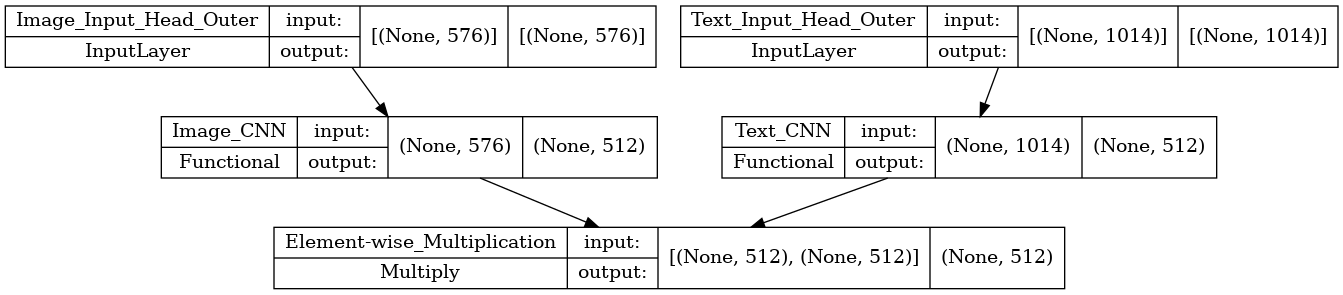

In [90]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

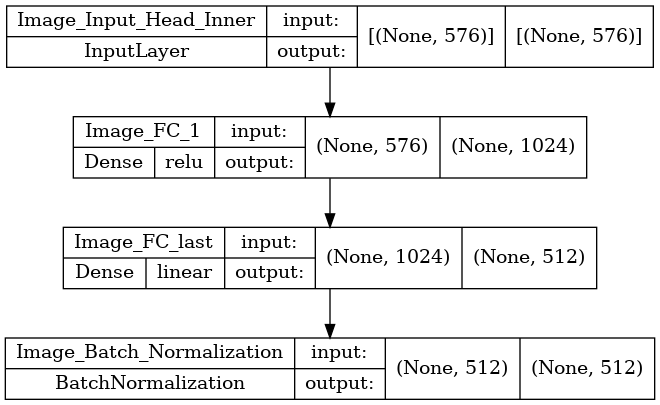

In [91]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

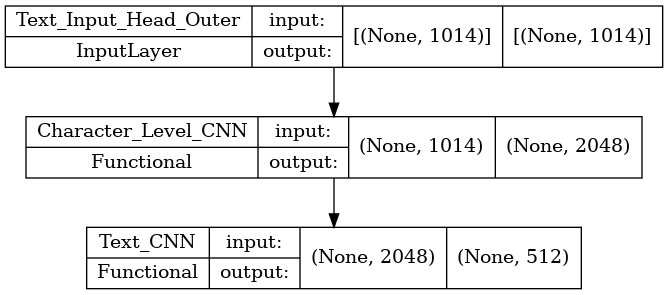

In [92]:
# Text CNN (outer)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

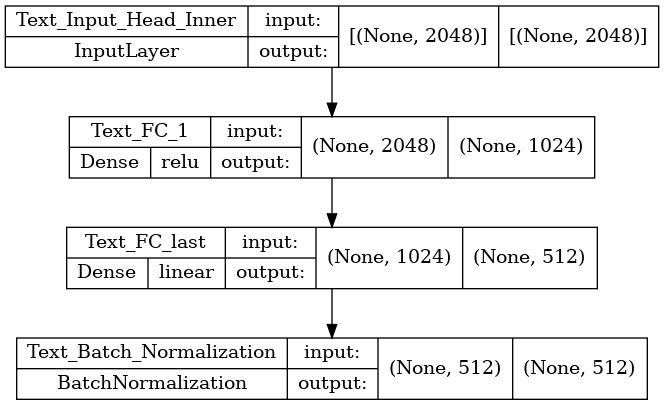

In [93]:
# Text CNN (inner)

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

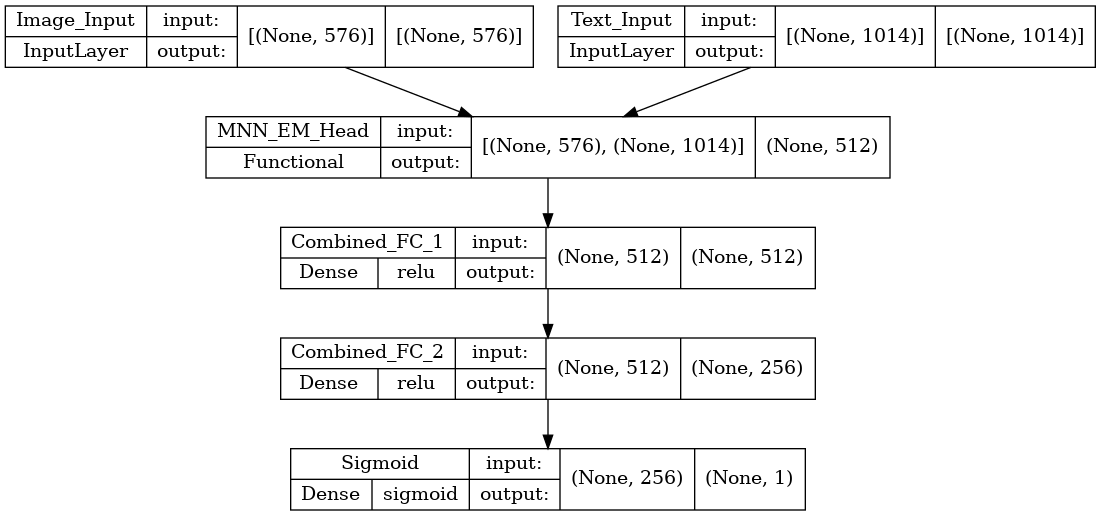

In [94]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [95]:
from utils.metrics import create_callbacks

In [96]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [97]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [98]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
16088/16090 [============================>.] - ETA: 0s - loss: 2.4179 - recall: 0.5949 - precision: 0.5611 - binary_accuracy: 0.5645 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 208s 13ms/step - loss: 2.4177 - recall: 0.5950 - precision: 0.5611 - binary_accuracy: 0.5645 - cosine_similarity: 0.5003 - val_loss: 0.7050 - val_recall: 0.7146 - val_precision: 0.6031 - val_binary_accuracy: 0.6200 - val_cosine_similarity: 0.5029
Epoch 2/10
16089/16090 [============================>.] - ETA: 0s - loss: 0.6658 - recall: 0.7583 - precision: 0.6076 - binary_accuracy: 0.6341 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 209s 13ms/step - loss: 0.6658 - recall: 0.7583 - precision: 0.6076 - binary_accuracy: 0.6341 - cosine_similarity: 0.5003 - val_loss: 0.6502 - val_recall: 0.6817 - val_precision: 0.6163 - val_binary_accuracy: 0.6265 - val_cosine_similarity: 0.5029
Epoch 3/10
16090/16090 [==============================] - 210s 13ms/step - loss: 0.6187 - recall: 0.7987 - precision: 0.6250 - binary_accuracy: 0.6596 - cosine_similarity: 0.5003 - val_loss: 0.6723 - val_recall: 0.7468 - val_precision: 0.5965 - val_binary_accuracy: 0.6187 - val_cosine_similarity: 0.5029
Epoch 4/10
16089/16090 [============================>.] - ETA: 0s - loss: 0.5909 - recall: 0.8135 - precision: 0.6427 - binary_accuracy: 0.6805 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 204s 13ms/step - loss: 0.5909 - recall: 0.8135 - precision: 0.6427 - binary_accuracy: 0.6805 - cosine_similarity: 0.5003 - val_loss: 0.5989 - val_recall: 0.8115 - val_precision: 0.6392 - val_binary_accuracy: 0.6749 - val_cosine_similarity: 0.5029
Epoch 5/10
16090/16090 [==============================] - 195s 12ms/step - loss: 0.5637 - recall: 0.8125 - precision: 0.6674 - binary_accuracy: 0.7036 - cosine_similarity: 0.5003 - val_loss: 0.6124 - val_recall: 0.7226 - val_precision: 0.6671 - val_binary_accuracy: 0.6791 - val_cosine_similarity: 0.5029
Epoch 6/10
16089/16090 [============================>.] - ETA: 0s - loss: 0.5321 - recall: 0.8195 - precision: 0.6973 - binary_accuracy: 0.7317 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 201s 13ms/step - loss: 0.5321 - recall: 0.8195 - precision: 0.6973 - binary_accuracy: 0.7317 - cosine_similarity: 0.5003 - val_loss: 0.5742 - val_recall: 0.7737 - val_precision: 0.6867 - val_binary_accuracy: 0.7087 - val_cosine_similarity: 0.5029
Epoch 7/10
16087/16090 [============================>.] - ETA: 0s - loss: 0.5047 - recall: 0.8335 - precision: 0.7197 - binary_accuracy: 0.7543 - cosine_similarity: 0.5003

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_Flickr30k/cls_0/MobilenetV3small/Adam/lr_1e-05/assets


16090/16090 [==============================] - 201s 12ms/step - loss: 0.5047 - recall: 0.8335 - precision: 0.7197 - binary_accuracy: 0.7543 - cosine_similarity: 0.5003 - val_loss: 0.5477 - val_recall: 0.7887 - val_precision: 0.7019 - val_binary_accuracy: 0.7253 - val_cosine_similarity: 0.5029
Epoch 8/10
16090/16090 [==============================] - 195s 12ms/step - loss: 0.4805 - recall: 0.8444 - precision: 0.7392 - binary_accuracy: 0.7731 - cosine_similarity: 0.5003 - val_loss: 0.6558 - val_recall: 0.7107 - val_precision: 0.6878 - val_binary_accuracy: 0.6923 - val_cosine_similarity: 0.5029
Epoch 9/10
16090/16090 [==============================] - 194s 12ms/step - loss: 0.4566 - recall: 0.8547 - precision: 0.7556 - binary_accuracy: 0.7890 - cosine_similarity: 0.5003 - val_loss: 0.5679 - val_recall: 0.8050 - val_precision: 0.7131 - val_binary_accuracy: 0.7391 - val_cosine_similarity: 0.5029
Epoch 10/10
16090/16090 [==============================] - 197s 12ms/step - loss: 0.4346 - recal

# Evaluation

## Plot loss and metrics

In [99]:
from utils.metrics import plot_metrics

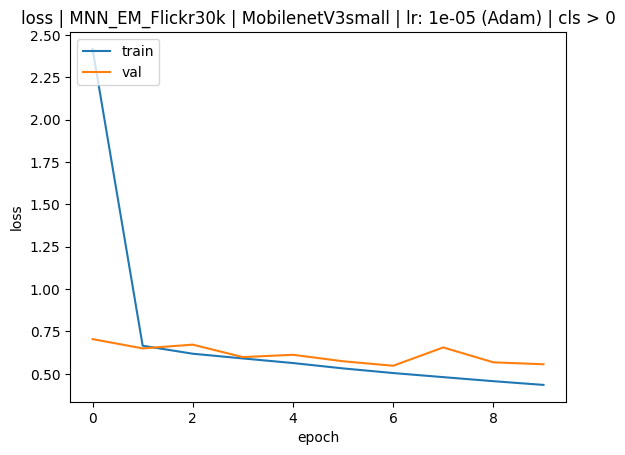

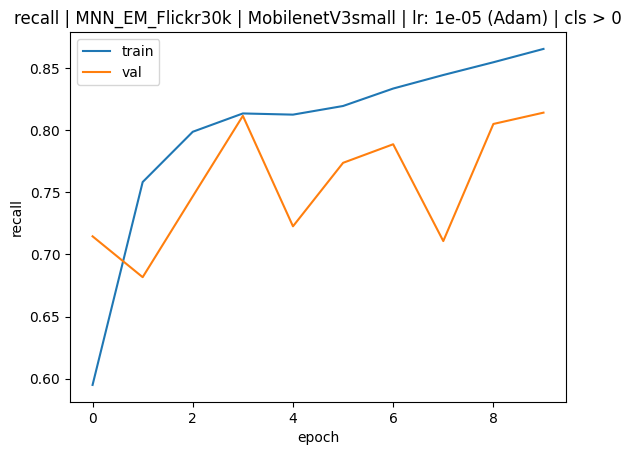

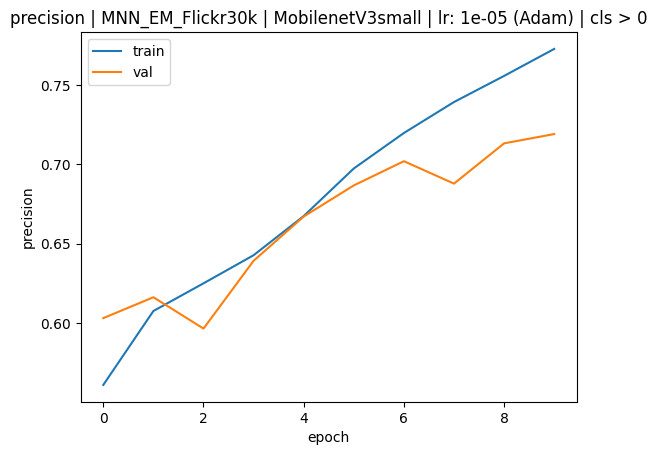

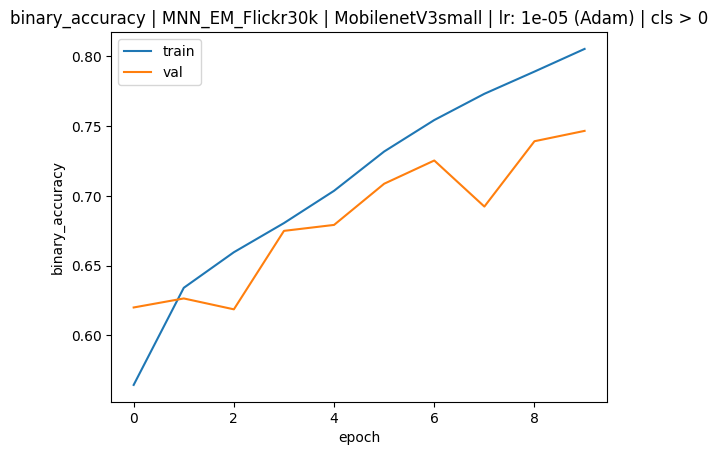

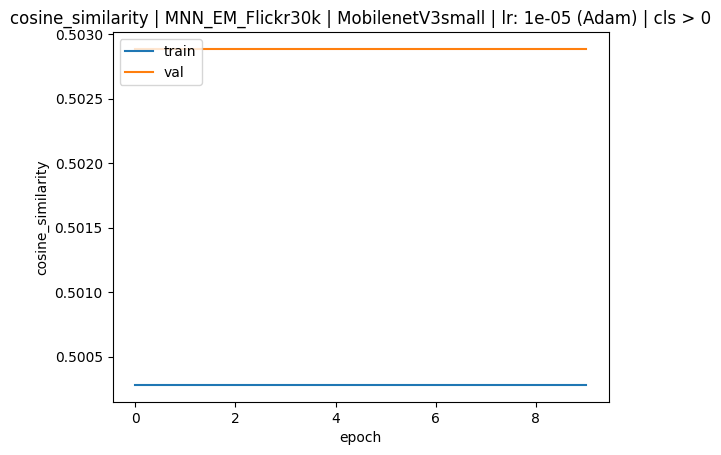

In [100]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [101]:
from utils.metrics import evaluate

In [102]:
evaluate(mnn_em.model, [img_test, text_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

31783/31783 [==============================] - 143s 4ms/step - loss: 0.5540 - recall: 0.8170 - precision: 0.7133 - binary_accuracy: 0.7468 - cosine_similarity: 0.4951
